# Laboratorijska vježba - Obrada informacija - Neuronske mreže

In [1]:
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118
!pip install torchsummary
!pip install numpy matplotlib opencv-python

Looking in indexes: https://download.pytorch.org/whl/cu118


In [2]:
!python -m pip install opencv-python

In [3]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader

from torchsummary import summary

# import cv2
import numpy as np
import matplotlib.pyplot as plt

import ast

# Zadatak 1 - Klasifikacija slike rukom pisanih znamenki

U prvom zadatku ove laboratorijske vježbe želimo analizirati utjecaj arhitekture mreže i drugih hiperparametara na uspješnost predikcije. Vaš zadatak je složiti nekoliko modela različitih karakteristika, te će te te modele istrenirati na problemu klasifikacije rukom pisanih znamenki.

Veliki dio koda koji je potreban za provođenje vježbe je dan. Vi ćete riješiti zadatak nadopunjavanjem koda. Također ste slobodni izmjeniti predloženi kod, ali ne preporuča se. Za labos je potreban Python 3.8+ i PyTorch 1.6+.

## Učitavanje podataka

Sljedeći kod priprema MNIST Dataset objekte koji dolaze s PyTorch paketom. Također instanciramo i DataLoader objekte koji rukuju sa mješanjem i batchanjem skupa podataka.

In [4]:
batch_size_train = 64
batch_size_test = 64

train_set = torchvision.datasets.MNIST('./files/', train=True, download=True,
                                       transform=torchvision.transforms.Compose([
                                           torchvision.transforms.ToTensor(),
                                           torchvision.transforms.Normalize((0.1307,), (0.3081,))])
                                      )


test_set = torchvision.datasets.MNIST('./files/', train=False, download=True,
                                      transform=torchvision.transforms.Compose([
                                          torchvision.transforms.ToTensor(),
                                          torchvision.transforms.Normalize((0.1307,), (0.3081,))])
                                     )

In [5]:
train_loader = DataLoader(train_set, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size_test, shuffle=True)

#### Podzadatak a)
Prikažite nekoliko primjera iz skupa za testiranje. Sliku pokažite pomoću `matplotlib` funkcije `imshow`. Neka `title` prikazane slike bude labela uzorka.

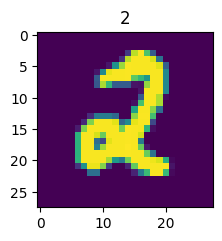

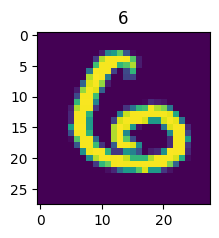

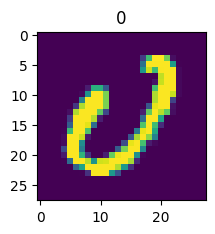

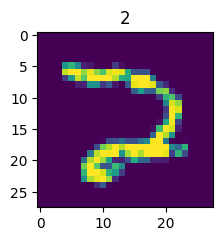

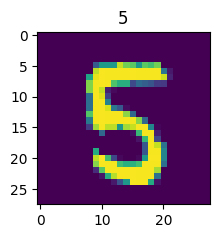

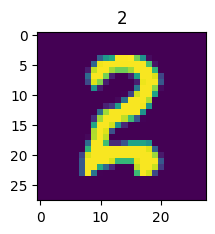

In [6]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)


fig = plt.figure()
for i in range(6):
  idx, (img,label) = next(examples)
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(img[i].numpy().transpose(1,2,0))
  plt.title(str(label[i].item()))
  plt.show()


## Pomoćne metode za treniranje neuronskih mreža

Nakon podzadataka ove sekcije postoji skup testova na kojima možete provjeriti točnost vaših pomoćnih funkcija. Bez točno rješenih pomoćnih funkcija ostatak labosa ne možete riješiti.

#### Podzadatak b) - Funkcija za određivanje broja parametara PyTorch modela

Jedna od metoda usporedbe naših modela će biti po broju parametara koji čine taj model. Radi toga je potrebno napisati metodu `get_number_of_model_parameters(model)` koja za predani model `model` vraća ukupni broj parametara tog modela.
Svaki PyTorch model sadrži implementaciju metode `.parameters()` koja vraća iterator nad parametrima modela. Ti parametri su tipa `torch.nn.parameter.Parameter`, čije dimenzije možemo dobiti pomoću `.shape` propertya.
Dovršite traženu metodu.

In [7]:
def get_number_of_model_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    return total_params

#### Podzadatak c) - Funkcija za treniranje modela

Model se trenira u četiri koraka.

1. Izračuna se prolaz unaprijed nad jednim batchom.
2. Na temelju dobivenog izlaza i točnih labela se računa gubitak. Kako je pokazano u demonstracijskoj bilježnici.
3. Izračunata greška se propagira unazad kroz mrežu radi računanja gradijenata.
4. Na temelju gradijenata, vrijednosti parametara i parametrima optimizatora (koji optimizator se koristi, kolika je stopa učenja, momentum i slično) se računa nova vrijednost parametara modela.

Implementirajte te korake u funkciji `train_step(train_loader, epoch, device, verbose)`.  

Napomene:
* Grešku koju trebate računati je "negative log likelihood loss", za koju PyTorch nudi implementaciju. Preporučamo da koristite gotovu implementaciju loss funkcije.
* Računanje gradijenata pomoću propagacije greške u nazad se računa pomoću metode `.backward()`. Nad kojim elementom pozivamo tu metodu?
* Korak optimizacije se radi pomoću `.step()` metode optimizator objekta. Pretpostavite da postoji objekt `optimizer` u globalnom scopeu.
* Pripazite da Vam se gradijenti ne akumuliraju kroz više koraka optimizacije. PyTorch modeli nude metodu `.zero_grad()` koja postavlja vrijednosti svih gradijenata nekog modela na 0.


In [8]:
def train_step(network, train_loader, epoch, device, verbose=True):
    train_losses = []
    train_counter = []

    network.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)

        network.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if (batch_idx % log_interval == 0):
            if verbose:
                print('Train Epoch: {:5d} [{:5d}/{:5d} ({:2.0f}%)]\tLoss: {:.6f}'.format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100. * batch_idx / len(train_loader),
                    loss.item()))

            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

    return train_losses, train_counter

#### Podzadatak d) - Funkcija za evaluaciju modela

Uspješnost učenja određujemo pomoću metrika točnosti. U ovoj laboratorijskoj vježbi pratimo dvije metrike - `negative log likelihood` i `accuracy`. Sa NLLLoss smo se već susreli; accuracy definiramo kao:

$ accuracy = \frac{\text{number of correctly classified samples}}{\text{total number of samples}} $

Nadopunite funkciju `test(network, test_loader, device, verbose)` tako da se model evaluira za navedene metrike.

U predloženom kodu se koristi `with torch.no_grad()`. Kako tijekom evaluacije ne mjenjamo parametre modela, gradijent nam nije potreban. Time ubrzavamo računanje (ne računa se gradijent), štedimo memoriju (izračunati gradijent se ne sprema) i spriječavamo buduće probleme (npr. ostanu gradijenti do sljedeće faze treniranja, gdje se gradijenti test seta iskoriste za učenje).

In [9]:
def test(network, test_loader, device, verbose=True):
    network.eval()

    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)

            output = network(data)
            test_loss+= F.nll_loss(output,target, reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1]
            correct+= pred.eq(target.data.view_as(pred)).sum()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    if verbose:
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {:5d}/{:5d} ({:2.2f}%)\n'.format(
            test_loss,
            correct,
            len(test_loader.dataset),
            accuracy))

    return test_loss, accuracy.item()

U sljedećoj fazi laboratorijske vježbe izvršavamo eksperimente, spremamo rezultate i uspoređujemo. Rezultate ćemo spremati u mapi `results`, tako da će `key` mape biti naziv eksperimenta, a vrijednost će biti `tuple` koji sadrži vrijednosti po kojima se model uspoređuje.

In [10]:
results = dict()

#### Podzadatak e) - Funkcija za provođenje cijelokupnog eksperimenta nad jednim modelom

Sada je vrijeme da se koraci iz prethodnih podzadataka objedine. Funkcija `train_network(network, train_loader, test_loader, device)` radi po sljedećem principu:

* Pretpostavlja se da u globalnom scopeu postoji varijabla imena `n_epochs` koja nam govori koliko epoha će se eksperiment izvršavati
* Liste `train_losses` i `test_losses` skupljaju loss vrijednosti tijekom treniranja, dok `train_counter` i `test_counter` skupljaju trenutke u kojima se metrika zabilježila (drugim riječima, to su X i Y os na grafu "loss po vremenu")
* prije samog treniranja se vrši testiranje modela, da se utvrdi performansa slučajnog modela
* U svakoj epohi se model trenira, testira i rezultati se zapisuju u odgovarajuće liste
* Funkcija vraća te liste na kraju

In [11]:
def train_network(network, train_loader, test_loader, device='cpu'):
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

    test_loss, accuracy = test(network,test_loader,device)
    test_losses.append(test_loss)

    for epoch in range(1, n_epochs + 1):
        new_train_losses,new_train_counter = train_step(network,
                                                        train_loader,
                                                        epoch,
                                                        device)
        test_loss,accuracy = test(network,
                                  test_loader,
                                  device)


        train_losses.extend(new_train_losses)
        train_counter.extend(new_train_counter)
        test_losses.append(test_loss)

    return train_losses, train_counter, test_losses, test_counter, accuracy

#### Testovi za utvrđivanje točnosti rada pomoćnih funkcija

Sljedeći kod služi kao pomoć za provjeru ispravnosti gore traženih pomoćnih funkcija. Generira se dataset u dva odvojena skupa, i cilj je naučiti model koji klasificira iz kojeg skupa točka dolazi. Prvo generiramo podatke i slažemo DataLoader:

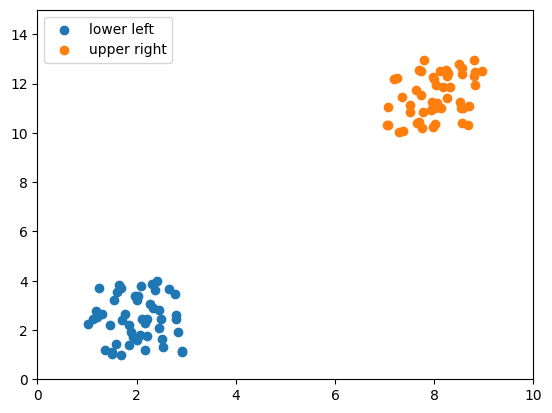

In [12]:
data_x = np.hstack([np.random.uniform(1, 3, 50), np.random.uniform(7, 9, 50)])
data_y = np.hstack([np.random.uniform(1, 4, 50), np.random.uniform(10, 13, 50)])
labels = [0 if x < 50 else 1 for x in range(0, 100)]

for idx, unique_label in enumerate(["lower left", "upper right"]):
    if idx == 0:
        plt.scatter(data_x[0:50], data_y[0:50], label=unique_label)
    if idx == 1:
        plt.scatter(data_x[50:], data_y[50:], label=unique_label)

plt.legend()
plt.xlim(0, 10)
plt.ylim(0, 15)


tensor_x = torch.Tensor(np.dstack([data_x, data_y]).reshape(100, 2).astype(np.float32))
tensor_y = torch.Tensor(labels).to(dtype=torch.int64)

toy_dataset = TensorDataset(tensor_x, tensor_y)
toy_dataloader = DataLoader(toy_dataset, batch_size=1, shuffle=True)

Nakon toga definiramo naš model. U ovom slučaju je model dvoslojna mreža sa dva potpuno povezana sloja.

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 4)
        self.fc2 = nn.Linear(4, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

Podešavamo parametre koje naše pomoćne funkcije očekivaju, te instanciramo model i optimizator.

In [14]:
n_epochs = 30
learning_rate = 0.01
log_interval = 33

network = Net().to('cpu')
optimizer = optim.SGD(network.parameters(), lr=learning_rate)

I sada možemo trenirati naš model. Vaše funkcije su ispravne ako točnost doesgne 100% (ili barem jako blizu). **Bez ispravnih pomoćnih funkcija nećete moći riješiti ostatak labosa.**

In [15]:
train_network(network, toy_dataloader, toy_dataloader, 'cpu')


Test set: Avg. loss: 0.6983, Accuracy:    50/  100 (50.00%)

Train Epoch:     1 [    0/  100 ( 0%)]	Loss: 0.799737
Train Epoch:     1 [   33/  100 (33%)]	Loss: 0.620567
Train Epoch:     1 [   66/  100 (66%)]	Loss: 0.671825
Train Epoch:     1 [   99/  100 (99%)]	Loss: 0.626734

Test set: Avg. loss: 0.6958, Accuracy:    50/  100 (50.00%)

Train Epoch:     2 [    0/  100 ( 0%)]	Loss: 0.622408
Train Epoch:     2 [   33/  100 (33%)]	Loss: 0.629116
Train Epoch:     2 [   66/  100 (66%)]	Loss: 0.626351
Train Epoch:     2 [   99/  100 (99%)]	Loss: 0.658171

Test set: Avg. loss: 0.6940, Accuracy:    50/  100 (50.00%)

Train Epoch:     3 [    0/  100 ( 0%)]	Loss: 0.734396
Train Epoch:     3 [   33/  100 (33%)]	Loss: 0.630665
Train Epoch:     3 [   66/  100 (66%)]	Loss: 0.726592
Train Epoch:     3 [   99/  100 (99%)]	Loss: 0.679884

Test set: Avg. loss: 0.6933, Accuracy:    50/  100 (50.00%)

Train Epoch:     4 [    0/  100 ( 0%)]	Loss: 0.675029
Train Epoch:     4 [   33/  100 (33%)]	Loss: 0.714

([0.7997374534606934,
  0.6205674409866333,
  0.6718249917030334,
  0.62673419713974,
  0.6224080920219421,
  0.6291157603263855,
  0.6263512372970581,
  0.6581714153289795,
  0.7343959808349609,
  0.6306650638580322,
  0.7265916466712952,
  0.6798839569091797,
  0.6750287413597107,
  0.7146207094192505,
  0.7331897616386414,
  0.7023041248321533,
  0.6890856027603149,
  0.6643373966217041,
  0.7045714855194092,
  0.6906999945640564,
  0.7006127834320068,
  0.702650785446167,
  0.6811816096305847,
  0.6898501515388489,
  0.6848955154418945,
  0.671979546546936,
  0.7151602506637573,
  0.6966233849525452,
  0.6916012167930603,
  0.7186577320098877,
  0.6764358282089233,
  0.7006453275680542,
  0.690717339515686,
  0.6705412268638611,
  0.6765748858451843,
  0.7029601335525513,
  0.697874903678894,
  0.6747435927391052,
  0.7095584869384766,
  0.6953765749931335,
  0.6959352493286133,
  0.726001501083374,
  0.6873390078544617,
  0.6926404237747192,
  0.6876579523086548,
  0.7050787210464

## Provođenje eksperimenata i analiza rezultata

#### Podzadatak f) - Eksperimenti

Sljedeća faza labosa je korištenje naših funkcija u okviru eksperimenata. Potrebno je testirati sljedeće modele:

* **Plitki model sa uskim slojevima**
    * Model je plitak po tome što nema puno slojeva (ne ide u dubinu) i uzak po tome što sami slojevi nemaju veliki broj elemenata (npr. 1 sloj sa 100 neurona umjesto 10 slojeva sa 10 neurona)
    * Arhitektura modela je sljedeća:
        * Konvolucijski sloj 5x5x10
        * Dropout (za regularizaciju)
        * Max pooling
        * ReLU aktivacija
        * Potpuno povezani sloj sa 20 neurona, ReLU aktivacija
        * Potpuno povezani sloj za klasifikaciju u 10 klasa, log softmax aktivacijska funkcija
    * U `results` mapi se sprema pod ključem `shallow_and_narrow_{stopa učenja}`
* **Plitki model sa širokim slojevima**
    * Ovaj model također nema puno slojeva, ali ti slojevi imaju puno elemenata
    * Arhitektura modela je sljedeća:
        * Konvolucijski sloj 5x5x40
        * Dropout (za regularizaciju)
        * Max pooling
        * ReLU aktivacija
        * Potpuno povezani sloj sa 64 neurona, ReLU aktivacija
        * Potpuno povezani sloj za klasifikaciju u 10 klasa, log softmax aktivacijska funkcija
    * U `results` mapi se sprema pod ključem `shallow_and_wide_{stopa učenja}`
* **Duboki model sa uskim slojevima**
    * Ovaj model ima puno slojeva, ali su ti slojevi ograničeni u svojoj širini
    * Arhitektura modela je sljedeća:
        * Konvolucijski sloj 5x5x10, ReLU aktivacijska funkcija
        * Max pooling
        * Konvolucijski sloj 5x5x20, ReLU aktivacijska funkcija
        * Max pooling
        * Potpuno povezani sloj sa 64 neurona, ReLU aktivacija
        * Dropout (za regularizaciju)
        * Potpuno povezani sloj za klasifikaciju u 10 klasa, log softmax aktivacijska funkcija
    * U `results` mapi se sprema pod ključem `deep_and_narrow_{stopa učenja}`
* **Duboki model sa širokim slojevima**
    * Model koji ima sve komponente dobro (ili previše?) zastupljene.
    * Arhitektura modela je sljedeća:
        * Konvolucijski sloj 5x5x32, ReLU aktivacijska funkcija
        * Max pooling
        * Konvolucijski sloj 5x5x64, ReLU aktivacijska funkcija
        * Max pooling
        * Potpuno povezani sloj sa 50 neurona, ReLU aktivacija
        * Dropout (za regularizaciju)
        * Potpuno povezani sloj za klasifikaciju u 10 klasa, log softmax aktivacijska funkcija
    * U `results` mapi se sprema pod ključem `deep_and_wide_{stopa učenja}`


Implementirajte `.__init__(self)` i `.forward(self, x)` metode za svaki od opisanih modela, trenirajte ih, evaluirajte i spremite metrike. **Ponovite taj postupak za 3 različite stope učenja: 0.0000001, 0.01 i 1.**

Sve potrebne slojeve za ostvarenje navedenih modela možete pronaći u torch.nn modulu. Detalje možete pronaći u službenoj PyTorch dokumentaciji: https://pytorch.org/docs/stable/index.html

**Spremite si najbolji model. Biti će potreban u podzadatku h)**.

Prvo je potrebno podesiti parametre. Parametri su sljedeći:
* n_epochs - broj epoha eksperimenta
* learning_rate - stopa učenja
* log_interval - broj koraka između dva ispisa tijekom treniranja (ispis se događa samo ako se funkcija poziva s argumentom verbose=True)
* device - oznaka na kojem se uređaju izvršava eksperiment; "cuda" za GPU, "cpu" za CPU

In [16]:
n_epochs = 3
learning_rate = 0.01
log_interval = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Naš model definiramo u klasi "Net" koja nasljeđuje nn.Module. Nadjačajte metode `__init__(self)` i `forward(self, x)` kako je opisano u tekstu zadatka.

In [17]:
class DeepWideModel(nn.Module):
    def __init__(self):
        super(DeepWideModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 50)
        self.drop = nn.Dropout(0.5)
        self.fc2 = nn.Linear(50, 10)

         
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(x.size(0), -1)  
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [18]:
class DeepNarrowModel(nn.Module):
    def __init__(self):
        super(DeepNarrowModel, self).__init__()
        self.conv1 = nn.Conv2d(1,10, kernel_size=5)
        self.conv2 = nn.Conv2d(10,20, kernel_size=5)
        self.fc1 = nn.Linear(20 * 4 * 4 ,64)
        self.drop = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64,10)
         
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 20 * 4 * 4) 
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [19]:
class ShallowWideModel(nn.Module):
    def __init__(self):
        super(ShallowWideModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 40, 5)
        self.drop = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(40 * 12 * 12, 64) 
        self.fc2 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.drop(x)
        x = F.relu(F.max_pool2d(x, 2))
        x = x.view(-1, 40 * 12 * 12)  
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [20]:
class ShallowNarrowModel(nn.Module):
    def __init__(self):
        super(ShallowNarrowModel, self).__init__()
        self.conv1 = nn.Conv2d(1,10, 5)
        self.drop = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(10 * 12 * 12, 20)
        self.fc2 = nn.Linear(20, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x  = self.drop(x)
        x = F.relu(F.max_pool2d(x, 2))
        x = x.view(-1, 10 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Da bi trenirali naš model, potrebno je napraviti instancu mreže i optimizatora. Koristite Stohastic Gradient Descent optimizator iz torch.optim modula. Detalji se mogu pronaći u službenoj dokuemntaciji PyTorcha za optim modul: https://pytorch.org/docs/stable/optim.html

In [21]:
network = DeepWideModel().to(device)
optimizer = optim.SGD(network.parameters(), lr=learning_rate)


Iskoristimo našu pripremljenu funkciju za izvođenje eksperimenta:

In [23]:
train_losses, train_counter, test_losses, test_counter, test_accuracy = train_network(network, train_loader, test_loader, device)


Test set: Avg. loss: 0.1017, Accuracy:  9686/10000 (96.86%)

Train Epoch:     1 [    0/60000 ( 0%)]	Loss: 0.226923
Train Epoch:     1 [ 6400/60000 (11%)]	Loss: 0.289377
Train Epoch:     1 [12800/60000 (21%)]	Loss: 0.297094
Train Epoch:     1 [19200/60000 (32%)]	Loss: 0.216143
Train Epoch:     1 [25600/60000 (43%)]	Loss: 0.305285
Train Epoch:     1 [32000/60000 (53%)]	Loss: 0.148868
Train Epoch:     1 [38400/60000 (64%)]	Loss: 0.263580
Train Epoch:     1 [44800/60000 (75%)]	Loss: 0.184630
Train Epoch:     1 [51200/60000 (85%)]	Loss: 0.306299
Train Epoch:     1 [57600/60000 (96%)]	Loss: 0.290373

Test set: Avg. loss: 0.0741, Accuracy:  9764/10000 (97.64%)

Train Epoch:     2 [    0/60000 ( 0%)]	Loss: 0.187588
Train Epoch:     2 [ 6400/60000 (11%)]	Loss: 0.215135
Train Epoch:     2 [12800/60000 (21%)]	Loss: 0.346964
Train Epoch:     2 [19200/60000 (32%)]	Loss: 0.224003
Train Epoch:     2 [25600/60000 (43%)]	Loss: 0.111374
Train Epoch:     2 [32000/60000 (53%)]	Loss: 0.326307
Train Epoch:

Spremimo rezultate u mapu `results` kako je navedeno u zadatku. Također nam je potreban broj parametara mreže, što možemo izračunati u ovom koraku.

## Spremanje modela 

In [24]:
state = {
    'model_state_dict': network.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'train_counter': train_counter,
    'test_losses': test_losses,
    'test_counter': test_counter,
    'test_accuracy': test_accuracy
}

torch.save(state, 'models/deep_and_wide_0.01.pth')

In [25]:
number_of_parameters = get_number_of_model_parameters(network)
results[f'deep_and_wide_{learning_rate}'] = (train_counter, train_losses, test_counter, test_losses, test_accuracy, number_of_parameters)

In [26]:
network = DeepNarrowModel().to(device)
optimizer = optim.SGD(network.parameters(), lr=learning_rate)

train_losses, train_counter, test_losses, test_counter, test_accuracy = train_network(network, train_loader, test_loader, device)


Test set: Avg. loss: 2.3188, Accuracy:  1029/10000 (10.29%)

Train Epoch:     1 [    0/60000 ( 0%)]	Loss: 2.330565
Train Epoch:     1 [ 6400/60000 (11%)]	Loss: 2.202256
Train Epoch:     1 [12800/60000 (21%)]	Loss: 1.696367
Train Epoch:     1 [19200/60000 (32%)]	Loss: 1.267135
Train Epoch:     1 [25600/60000 (43%)]	Loss: 0.907444
Train Epoch:     1 [32000/60000 (53%)]	Loss: 0.733695
Train Epoch:     1 [38400/60000 (64%)]	Loss: 0.563696
Train Epoch:     1 [44800/60000 (75%)]	Loss: 0.672614
Train Epoch:     1 [51200/60000 (85%)]	Loss: 0.813727
Train Epoch:     1 [57600/60000 (96%)]	Loss: 0.627979

Test set: Avg. loss: 0.3070, Accuracy:  9119/10000 (91.19%)

Train Epoch:     2 [    0/60000 ( 0%)]	Loss: 0.535334
Train Epoch:     2 [ 6400/60000 (11%)]	Loss: 0.461053
Train Epoch:     2 [12800/60000 (21%)]	Loss: 0.467164
Train Epoch:     2 [19200/60000 (32%)]	Loss: 0.492416
Train Epoch:     2 [25600/60000 (43%)]	Loss: 0.338818
Train Epoch:     2 [32000/60000 (53%)]	Loss: 0.209861
Train Epoch:

In [27]:
number_of_parameters = get_number_of_model_parameters(network)
results[f'deep_and_narrow_{learning_rate}'] = (train_counter, train_losses, test_counter, test_losses, test_accuracy, number_of_parameters)

In [28]:
network = ShallowNarrowModel().to(device)
optimizer = optim.SGD(network.parameters(), lr=learning_rate)

train_losses, train_counter, test_losses, test_counter, test_accuracy = train_network(network, train_loader, test_loader, device)


Test set: Avg. loss: 2.2955, Accuracy:   961/10000 (9.61%)

Train Epoch:     1 [    0/60000 ( 0%)]	Loss: 2.318313
Train Epoch:     1 [ 6400/60000 (11%)]	Loss: 1.485010
Train Epoch:     1 [12800/60000 (21%)]	Loss: 0.750577
Train Epoch:     1 [19200/60000 (32%)]	Loss: 0.537717
Train Epoch:     1 [25600/60000 (43%)]	Loss: 0.445561
Train Epoch:     1 [32000/60000 (53%)]	Loss: 0.326284
Train Epoch:     1 [38400/60000 (64%)]	Loss: 0.479868
Train Epoch:     1 [44800/60000 (75%)]	Loss: 0.589397
Train Epoch:     1 [51200/60000 (85%)]	Loss: 0.285376
Train Epoch:     1 [57600/60000 (96%)]	Loss: 0.450631

Test set: Avg. loss: 0.2907, Accuracy:  9144/10000 (91.44%)

Train Epoch:     2 [    0/60000 ( 0%)]	Loss: 0.260655
Train Epoch:     2 [ 6400/60000 (11%)]	Loss: 0.195623
Train Epoch:     2 [12800/60000 (21%)]	Loss: 0.296811
Train Epoch:     2 [19200/60000 (32%)]	Loss: 0.363208
Train Epoch:     2 [25600/60000 (43%)]	Loss: 0.572128
Train Epoch:     2 [32000/60000 (53%)]	Loss: 0.218939
Train Epoch: 

In [29]:
number_of_parameters = get_number_of_model_parameters(network)
results[f'shallow_and_narrow_{learning_rate}'] = (train_counter, train_losses, test_counter, test_losses, test_accuracy, number_of_parameters)

In [30]:
network = ShallowWideModel().to(device)
optimizer = optim.SGD(network.parameters(), lr=learning_rate)

train_losses, train_counter, test_losses, test_counter, test_accuracy = train_network(network, train_loader, test_loader, device)


Test set: Avg. loss: 2.3062, Accuracy:   795/10000 (7.95%)

Train Epoch:     1 [    0/60000 ( 0%)]	Loss: 2.328750
Train Epoch:     1 [ 6400/60000 (11%)]	Loss: 0.650346
Train Epoch:     1 [12800/60000 (21%)]	Loss: 0.461330
Train Epoch:     1 [19200/60000 (32%)]	Loss: 0.347681
Train Epoch:     1 [25600/60000 (43%)]	Loss: 0.410762
Train Epoch:     1 [32000/60000 (53%)]	Loss: 0.287115
Train Epoch:     1 [38400/60000 (64%)]	Loss: 0.400142
Train Epoch:     1 [44800/60000 (75%)]	Loss: 0.297381
Train Epoch:     1 [51200/60000 (85%)]	Loss: 0.233950
Train Epoch:     1 [57600/60000 (96%)]	Loss: 0.233664

Test set: Avg. loss: 0.2637, Accuracy:  9152/10000 (91.52%)

Train Epoch:     2 [    0/60000 ( 0%)]	Loss: 0.307560
Train Epoch:     2 [ 6400/60000 (11%)]	Loss: 0.214597
Train Epoch:     2 [12800/60000 (21%)]	Loss: 0.263540
Train Epoch:     2 [19200/60000 (32%)]	Loss: 0.262997
Train Epoch:     2 [25600/60000 (43%)]	Loss: 0.122185
Train Epoch:     2 [32000/60000 (53%)]	Loss: 0.317970
Train Epoch: 

In [31]:
number_of_parameters = get_number_of_model_parameters(network)
results[f'shallow_and_wide_{learning_rate}'] = (train_counter, train_losses, test_counter, test_losses, test_accuracy, number_of_parameters)

In [32]:
import os
import csv

def append_results_to_csv(results, file_path):
    headers = ['model_key', 'train_counter', 'train_losses', 'test_counter', 'test_losses', 'test_accuracy', 'number_of_parameters']

    file_exists = os.path.isfile(file_path)

    with open(file_path, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        
        if not file_exists:
            writer.writerow(headers)

        for key, value in results.items():
            row = [key] + list(value)
            writer.writerow(row)

In [33]:
append_results_to_csv(results, 'results.csv')

Prikažimo rezultate za ovaj eksperiment:

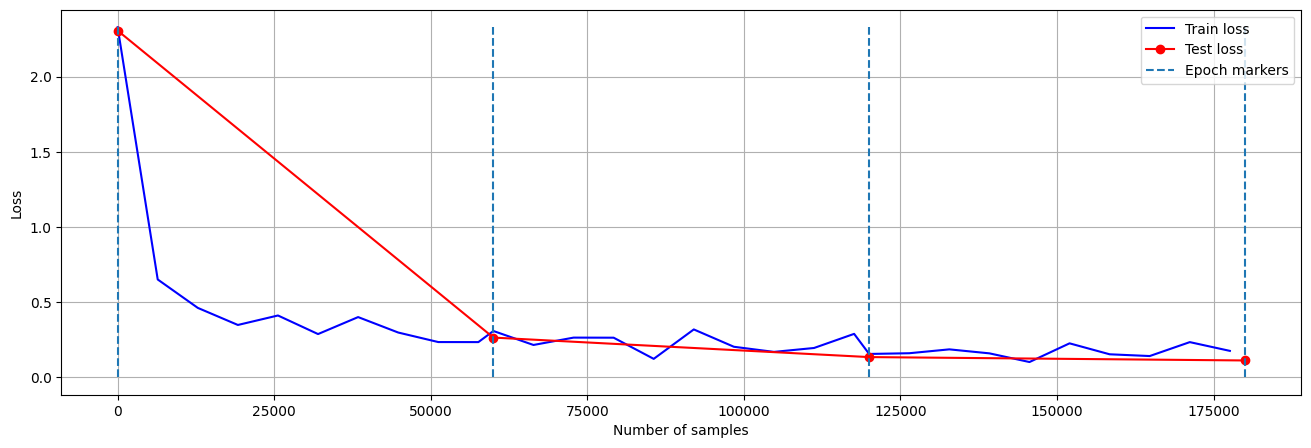

In [34]:
fig = plt.figure(figsize=(16, 5))
plt.plot(train_counter, train_losses, color='blue', label='Train loss')
plt.plot(test_counter, test_losses, color='red',  marker='o', label='Test loss')
plt.vlines(test_counter, 0, max(train_losses + test_losses), linestyles='dashed', label='Epoch markers')

plt.legend(loc='upper right')
plt.xlabel('Number of samples')
plt.ylabel('Loss')
plt.grid()

**Vizualizacije modela sa svim stopama učenja.**

In [35]:
def visualize_model(train_counter, train_losses, test_counter, test_losses,model_name):
   fig = plt.figure(figsize=(16, 5))
   plt.plot(train_counter, train_losses, color='blue', label='Train loss')
   plt.plot(test_counter, test_losses, color='red',  marker='o', label='Test loss')
   plt.vlines(test_counter, 0, max(train_losses + test_losses), linestyles='dashed', label='Epoch markers')

   plt.legend(loc='upper right')
   plt.xlabel('Number of samples')
   plt.ylabel('Loss')
   plt.title(str(model_name))
   plt.grid()

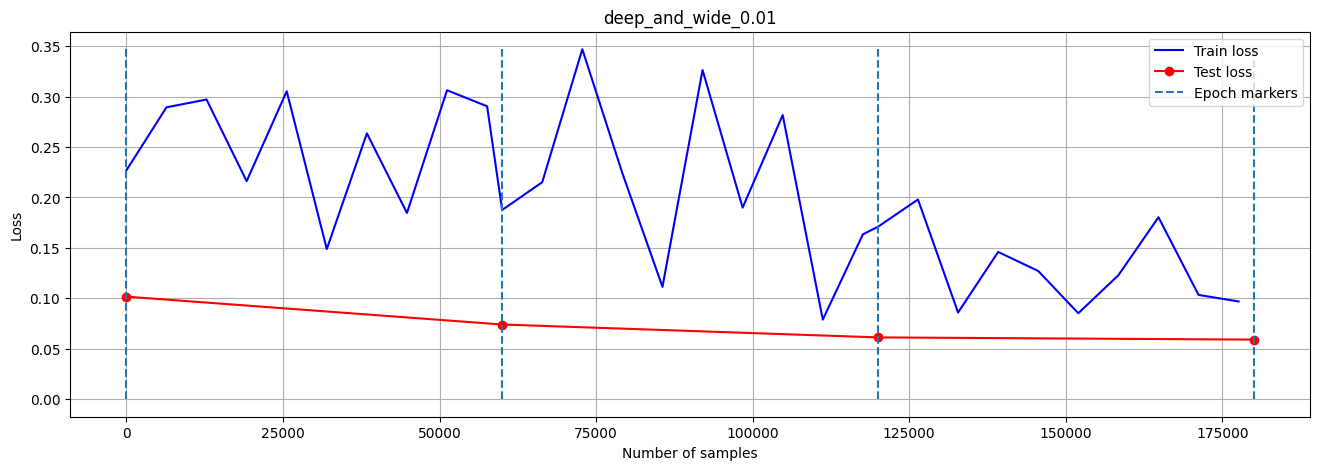

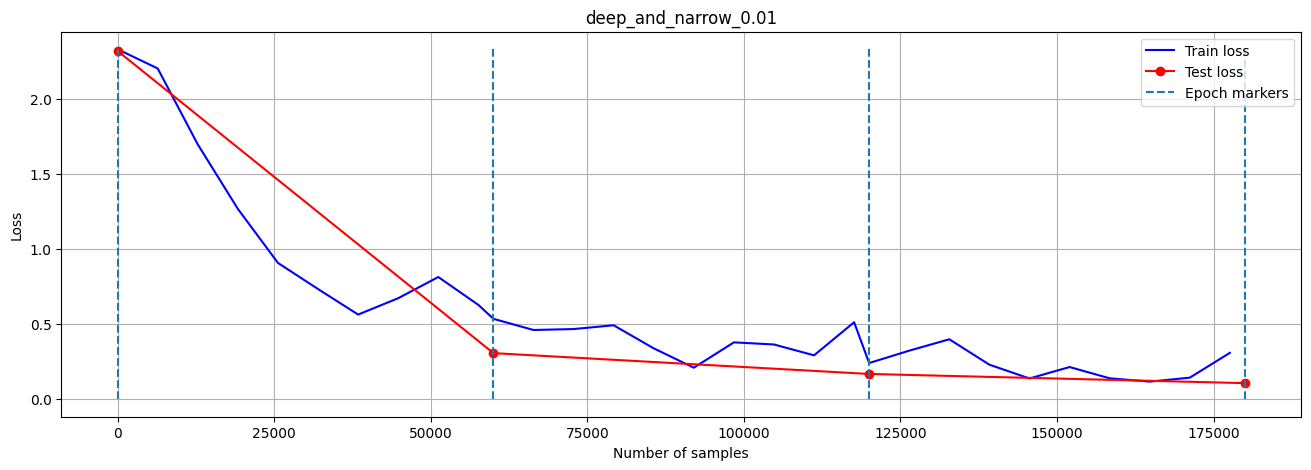

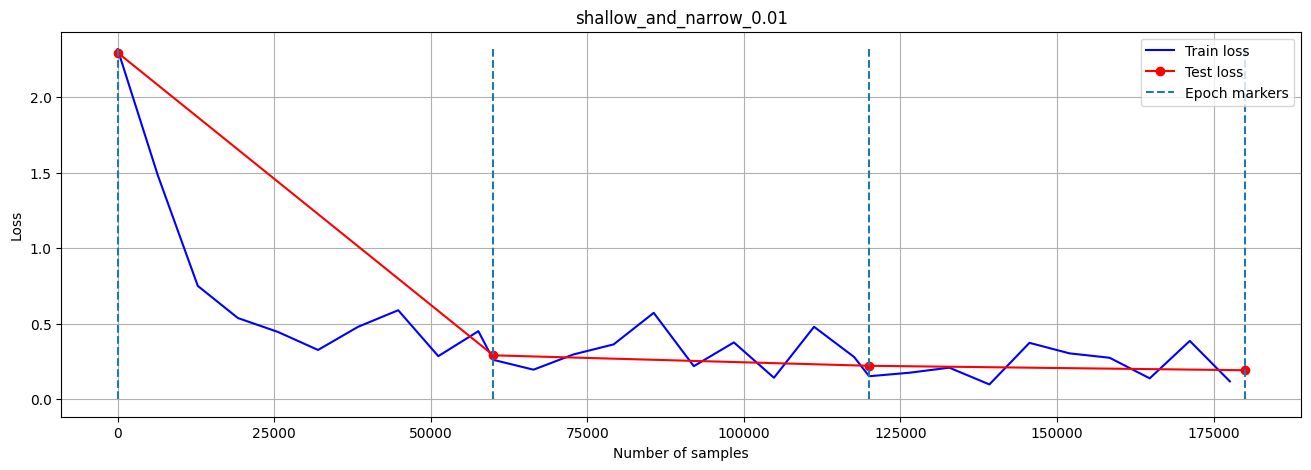

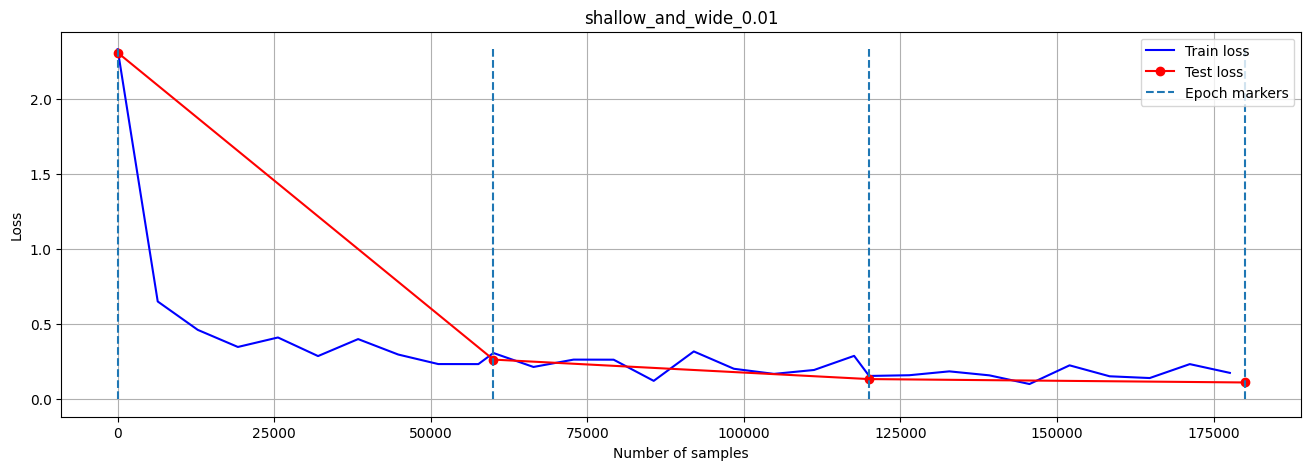

In [36]:
with open('results.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        model_key = row['model_key']
        train_counter = ast.literal_eval(row['train_counter'])
        try:
            train_losses = ast.literal_eval(row['train_losses'])
        except ValueError:
            print(f"There are some nan's due to gradient explosion for model {model_key}")
            continue

        test_counter = ast.literal_eval(row['test_counter'])
        test_losses = ast.literal_eval(row['test_losses'])
        test_accuracy = float(row['test_accuracy'])  
        number_of_parameters = int(row['number_of_parameters']) 

        visualize_model(train_counter, train_losses, test_counter, test_losses, model_key)

#### Podzadatak g) - Usporedba rezultata

Nakon što smo izvršili sve eksperimente potrebno ih je usporediti. Nacrtajte tražene grafove, te pomoću njih odgovorite na pitanja postavljena na Moodleu.

Nacrtajte graf gdje je X os vrijeme (odgovara na pitanje: koji korak treniranja?), a Y os je loss za **trening** skup podataka.

Text(0.5, 0, 'Steps')

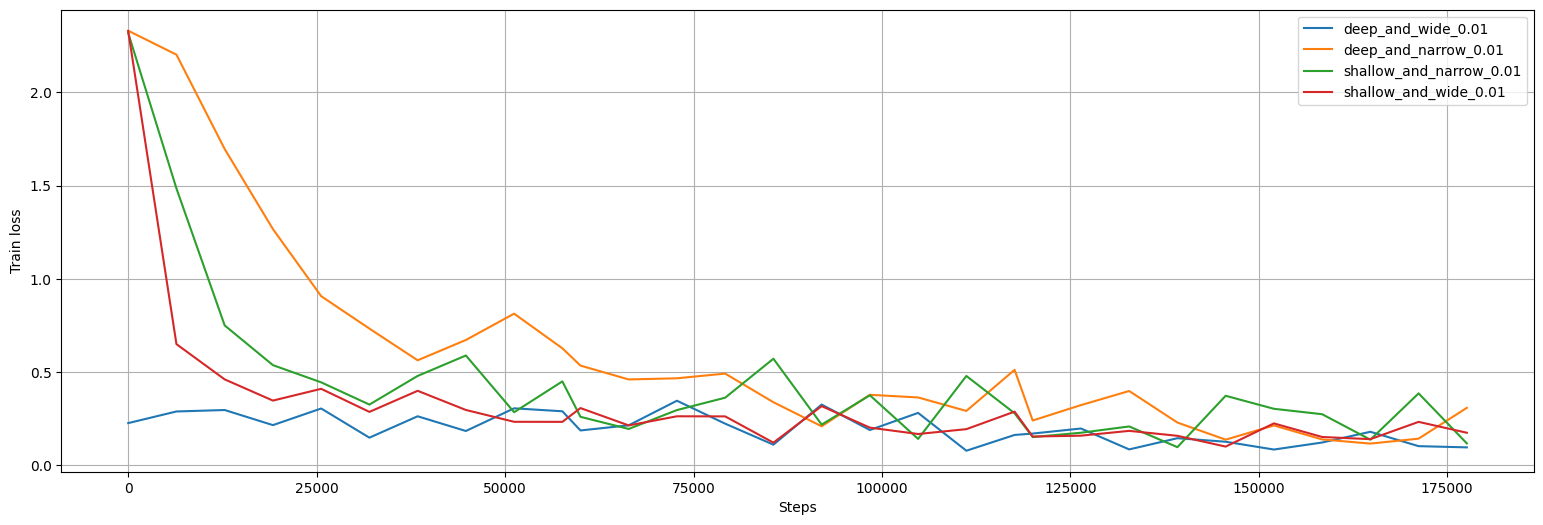

In [37]:
plt.figure(figsize=(19, 6))

for model_key in results:
    train_counter, train_losses, test_counter, test_losses, test_accuracy, number_of_parameters = results[model_key]
    plt.plot(train_counter, train_losses, label=model_key)

plt.legend()
plt.grid()
plt.ylabel("Train loss")
plt.xlabel("Steps")

Odgovorite na sljedeća pitanja:
1. Radi li se o konzistentnom padu iz koraka u korak?kroz cijeli trening.
2. Jesu li neke arhitekture u startu značajno bolje od drugih?
3. Koji model je najnestabilniji tijekom treniranja?


1. Kod stope učenja 0.01, konzistentan je pad, za premalu i preveliku stopu učenja, pad gubitka je neznatan te u biti stagnira 
2. Ne, nema značajnije razlike po strukturama. Kod stope učenja od 0.01 vidimo kako sve ostižu sličnu preciznost i akumulirani gubitak u početnom  prolazu.
3. Duboki široki model, za stopu učenja od 1, kako dolazi do eksplozije gradijenta. 

Text(0.5, 0, 'Steps')

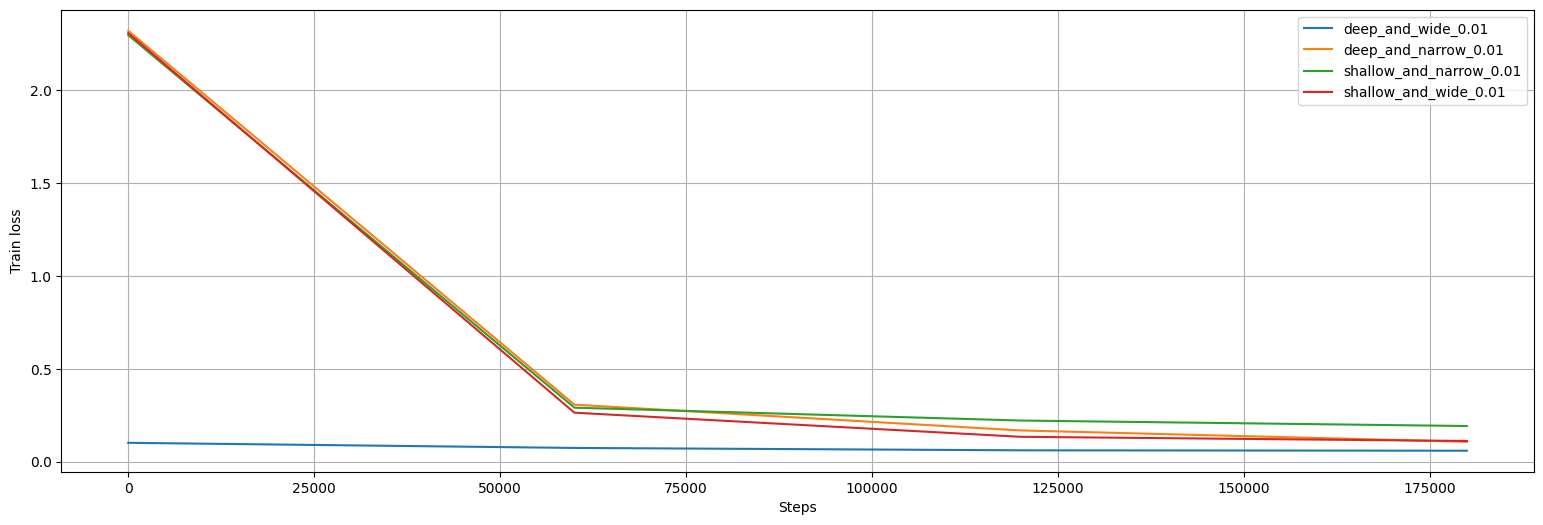

In [38]:
plt.figure(figsize=(19, 6))

for model_key in results:
    train_counter, train_losses, test_counter, test_losses, test_accuracy, number_of_parameters = results[model_key]
    plt.plot(test_counter, test_losses, label=model_key)

plt.legend()
plt.grid()
plt.ylabel("Train loss")
plt.xlabel("Steps")

Nacrtajte graf gdje je X os vrijeme (odgovara na pitanje: koji korak treniranja?), a Y os je loss za **test** skupu podataka.

Odgovorite na sljedeća pitanja:
4. Radi li se o konzistentnom padu iz koraka u korak?
5. Jesu li neke arhitekture u startu značajno bolje od drugih?

Isti odgovor kao i na prethodno pitanje, što je očekivano za jako dobre ili loše modele, ako u našem slučaju (loše aproksimatore).

Text(0, 0.5, 'Steps')

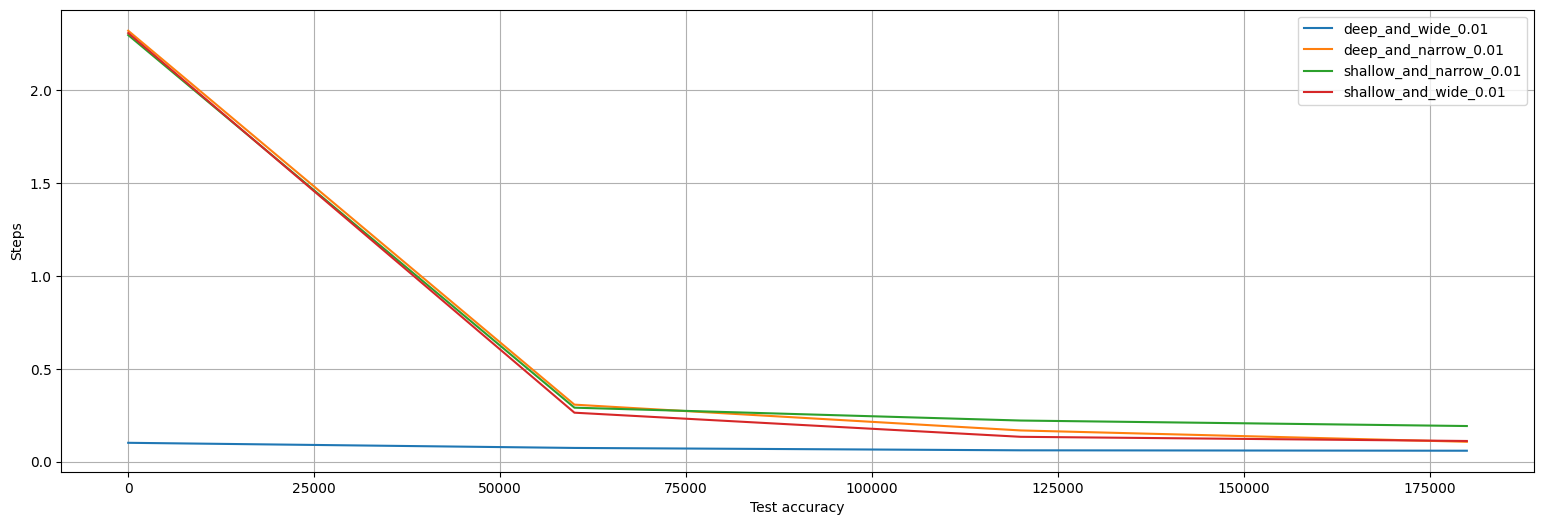

In [39]:
plt.figure(figsize=(19, 6))

for model_key in results:
    train_counter, train_losses, test_counter, test_losses, test_accuracy, number_of_parameters = results[model_key]
    plt.plot(test_counter, test_losses, label=model_key)

plt.legend()
plt.grid()
plt.xlabel("Test accuracy")
plt.ylabel("Steps")

Nacrtajte graf (scatter plot) gdje je X os broj parametara modela, a Y os je točnost koju model ostvaruje na test skupu.

Odgovorite na sljedeća pitanja:
6. Koji je najbolji model?
7. Kakvi su duboki modeli u usporedbu s plitkim modelima?
8. Kakvi su široki modeli u usporedbi s uskima?

Nema najboljeg modela u smislu preciznosti, kako svi modeli sa stopom učenja 0.01 postižu  visoku preciznost. Širi modeli imaju osjetljivo više parametara od 
uskih, no zadatak je prejednostavan da bi se to odrazilo na preciznost. 

Text(0.5, 0, 'Number of parameters')

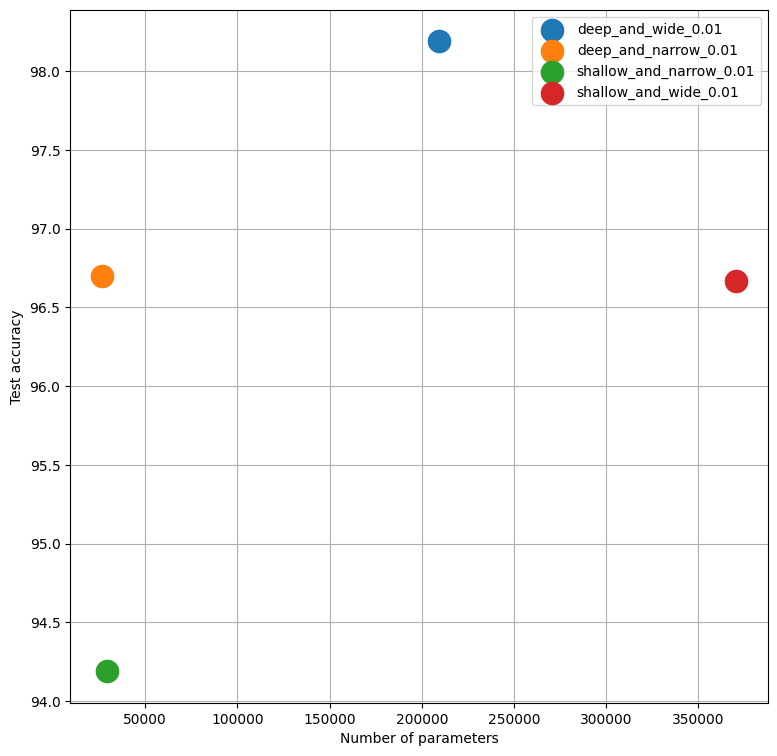

In [40]:
plt.figure(figsize=(9, 9))

for model_key in results:
    train_counter, train_losses, test_counter, test_losses, test_accuracy, number_of_parameters = results[model_key]
    plt.scatter(number_of_parameters, test_accuracy, label=model_key, s=256)

plt.legend()
plt.grid()
plt.ylabel("Test accuracy")
plt.xlabel("Number of parameters")

#### Podzadatak h) - Evaluacija na neviđenom skupu podataka

Preuzmite skup podataka za ocjenjivanje sa sljedeće poveznice: https://drive.google.com/drive/folders/1baSno2jQSlyCPhk_liDlVvgXrIM5ojBB  
-> **submission_z1.zip**

Primjer filea kojeg treba generirati možete preuzeti sa: https://drive.google.com/drive/folders/1baSno2jQSlyCPhk_liDlVvgXrIM5ojBB

-> **zad1_submission_sample.csv**

Odredite predikcije Vašeg najboljeg modela nad tim skupom, te ih stavite na Moodle.

Prije pokretanja iduće ćelije svakako prenesite zip datoteku u radno okruženje.

In [46]:
import zipfile
import os
import csv

with zipfile.ZipFile('files/submission_z1.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

checkpoint = torch.load('models/deep_and_wide_0.01.pth')

model = DeepWideModel().to(device)
optimizer = optim.SGD(network.parameters(), lr=learning_rate)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model = model.to(device)
model.eval()

transform = torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Grayscale(num_output_channels=1),
                                torchvision.transforms.Normalize((0.1307,), (0.3081,))]
                               )

dataset = torchvision.datasets.ImageFolder('data', transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

results = []

for ind, (images, _) in enumerate(dataloader):
    images = images.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    image_name = dataset.imgs[ind][0].split('/')[-1]  # Extract image name
    results.append((image_name, predicted.item()))
    
def extract_number(file_name):
    try:
        return int(file_name.split('_')[1][:-4])
    except ValueError:
        return float('inf')
    
sorted_results = sorted(results, key=lambda x: extract_number(x[0]))

with open('files/submission_z1.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image_name', 'true_label'])
    writer.writerows(sorted_results)

## Zadatak 2 - Pronalazak znamenki na slici i klasifikacija pronađene znamenke

Drugi zadatak je proširenje naučenog u prvom zadatku. Problem se proširuje - umjesto klasifikacije rukom pisane znamenke, naš problem je sada pronalazak rukom pisane znamenke na slici **i** klasifikacija.

Kao i u prethodnoj vježbi, dani su dijelovi koda potrebnog za ostvarenje vježbe, a na Vama je da nadopunite dijelove koji nedostaju.

#### Skup podataka

Da bi mogli trenirati model za klasifikaciju i detekciju objekta na slici, moramo imati odgovarajući dataset. Koristimo postojeći MNIST dataset, a modificiramo ga tako da postavimo originalni MNIST uzorak na slučajnu poziciju na praznoj slici. Sljedeći kod generira takve uzorke, vraćajući modificiranu sliku, oznaku kategorije i poziciju znamenke na slici (*bounding box*).

In [42]:
class PositionMNIST(Dataset):

    def __init__(self, image_size=128, transform=None, train_set=False):
        self.image_size = image_size
        self.transform = transform

        self.set = torchvision.datasets.MNIST('./files/', train=train_set, download=True)
        self.position_cache = [-1] * len(self.set)

    def __len__(self):
        return len(self.set)

    def __getitem__(self, idx):
        if self.position_cache[idx] == -1:
            x_pos = int(np.random.uniform(0, self.image_size-29))
            y_pos = int(np.random.uniform(0, self.image_size-29))
            self.position_cache[idx] = (x_pos, y_pos)

        x_pos, y_pos = self.position_cache[idx]

        canvas = np.zeros((self.image_size, self.image_size, 1), dtype=np.uint8)
        canvas[y_pos:(y_pos+28), x_pos:(x_pos+28), 0] = self.set[idx][0]

        x_pos = float(x_pos)
        y_pos = float(y_pos)

        if self.transform is not None:
            canvas = self.transform(canvas)

        return canvas, self.set[idx][1], (x_pos, y_pos, x_pos+28, y_pos+28)

In [43]:
batch_size_train = 128
batch_size_test = 128
image_size = 128

train_set = PositionMNIST(train_set=True, image_size=image_size, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

test_set = PositionMNIST(train_set=False, image_size=image_size, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

In [44]:
train_loader = DataLoader(train_set, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size_test, shuffle=True)

#### Podzadatak a) - Vizualizacija podataka

Uzmite jedan uzorak pomoću data loadera i vizualizirajte ga. Neka u titleu piše klasa i lokacija.

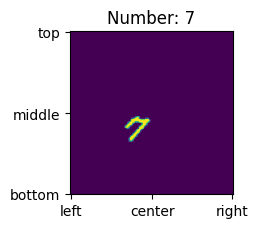

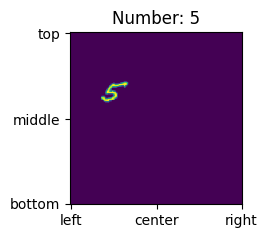

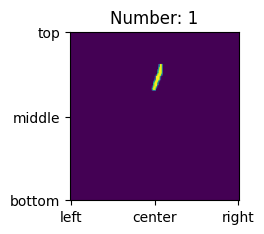

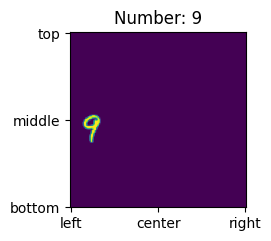

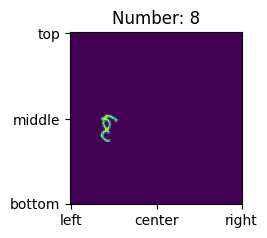

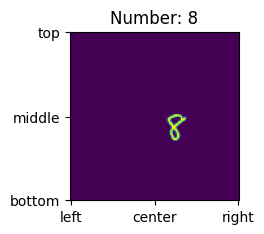

In [45]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_labels, example_positions) = next(examples)
fig = plt.figure(figsize=(9, 4))

for i in range(6):  
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()

    plt.xticks(ticks=[0, example_data.shape[2]//2, example_data.shape[2]-1], labels=['left', 'center', 'right'])
    plt.yticks(ticks=[0, example_data.shape[3]//2, example_data.shape[3]-1], labels=['top', 'middle', 'bottom'])

    plt.imshow(example_data[i].numpy().transpose(1, 2, 0))

    plt.title(f"Number: {example_labels[i]}")
    plt.show()


#### Podzadatak b) - Pomoćne funkcije za treniranje

Nadopunite pomoćne funkcije za treniranje neuronskih mreža po principu naučenom u 1. zadatku. Temeljna razlika između pomoćne funkcije iz prethodnog zadatke i pomoćne funkcije u ovom zadatku je:

1. Rukovanje s podacima (ovdje ih ima više)
2. Drugi problem rješavamo, stoga trebamo drugačiju loss funkciju.

Loss funkcija će se u ovom slučaju sastojati od dva dijela - loss za klasifikaciju s kojim smo se već upoznali, i prosječan kvadrat greške (*mean squared error*) za određivanje pozicije. Loss će se računa kao:

$ \mathcal{L} = \text{NLLLoss}(\text{classification output}, \text{target)} + \frac{(x_1 - \hat{x}_1)^2 + (y_1 - \hat{y}_1)^2 + (x_2 - \hat{x}_2)^2 + (y_2 - \hat{y}_2)^2}{128 \cdot 128}  $

Pri čemu su $x$ i $y$ točne pozicije objekta na slici, a $\hat{x}$ i $\hat{y}$ su modelom određene pozicije objekta.


In [54]:
def train_step(network, train_loader, optimizer, epoch, device, log_interval, verbose=True):
    train_losses = []
    train_counter = []

    classification_loss_fn = nn.NLLLoss()  

    network.train()

    for batch_idx, (data, target, position) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        position = [pos.to(device) for pos in position]

        network.zero_grad()
        output_clsf, *output_bbox = network(data)

        loss_clsf = classification_loss_fn(output_clsf, target) #-torch.sum(output_clsf[range(target.shape[0]), target])

        scale_factor = 128 * 128
        bbox_losses = [((position[i] - output_bbox[i])**2).mean() for i in range(4)]
        loss_bbox = sum(bbox_losses) / scale_factor

        loss = loss_clsf + loss_bbox
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            if verbose:
                print('Train Epoch: {:5d} [{:5d}/{:5d} ({:2.0f}%)]\tLoss: {:.6f}'.format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100. * batch_idx / len(train_loader),
                    loss.item()))

            train_losses.append(loss.item())
            train_counter.append((batch_idx * len(data)) + ((epoch - 1) * len(train_loader.dataset)))

    return train_losses, train_counter


Po istom principu iz 1. zadatka nadopunite funkciju za evaluaciju modela. U ovom slučaju mjerimo 3 stvari: sam loss, točnost klasifikacije i posebno loss za detekciju.

In [55]:
def test(network, test_loader, device, verbose=True):
        network.eval()

        test_loss_clsf = 0
        test_loss_bbox = 0
        correct = 0
        
        classification_loss_fn = nn.NLLLoss()  

        with torch.no_grad():
            for data, target, position in test_loader:
                data, target = data.to(device), target.to(device)
                position = [pos.to(device) for pos in position]

                output_clsf, *output_bbox = network(data)
                test_loss_clsf = classification_loss_fn(output_clsf, target)  
                 #-= torch.sum(output_clsf[range(target.shape[0]), target]).item()
                
                scale_factor = 128 * 128
                bbox_losses = [((position[i] - output_bbox[i])**2).mean() for i in range(4)]
                test_loss_bbox += sum(bbox_losses).item()  / scale_factor

                pred = output_clsf.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum()

        test_loss_clsf /= len(test_loader.dataset)
        test_loss_bbox /= len(test_loader.dataset)
        test_accuracy = 100. * correct / len(test_loader.dataset)

        if verbose:
            print('\n[Test] Classification: Avg. loss: {:.4f}, Accuracy: {:5d}/{:5d} ({:2.2f}%) | Object detection: Avg. loss: {:.4f}\n'.format(
                test_loss_clsf,
                correct,
                len(test_loader.dataset),
                test_accuracy,
                test_loss_bbox))

        return test_loss_clsf, test_accuracy, correct, test_loss_bbox


Pomoćna funkcija za provođene eksperimenata iz prethodnog zadatka je iskoristiva do na praćenje dodatnih metrika. Proširite tu funkciju za ovaj zadatak.

In [56]:
def train_network(network, train_loader, test_loader, n_epochs, device='cpu'):
    train_losses = []
    train_counter = []
    test_losses_clsf = []
    test_accuracies = []
    test_losses_bbox = []
    test_counter = [i*len(train_loader.dataset) for i in range(int(n_epochs) + 1)]

    test_loss_clsf, test_accuracy, _, test_loss_bbox = test(network, test_loader, device)
    test_losses_clsf.append(test_loss_clsf)
    test_accuracies.append(test_accuracy)
    test_losses_bbox.append(test_loss_bbox)
    
    for epoch in range(1, n_epochs + 1):
        epoch_train_loss, epoch_train_counter = train_step(network,
                                                           train_loader, 
                                                           optimizer,
                                                           epoch, 
                                                           device,
                                                           log_interval)

        test_loss_clsf, test_accuracy, _, test_loss_bbox = test(network, 
                                                                test_loader, 
                                                                device)
        train_losses.extend(epoch_train_loss)
        train_counter.extend(epoch_train_counter)
        test_losses_clsf.append(test_loss_clsf)
        test_losses_bbox.append(test_loss_bbox)
        test_accuracies.append(test_accuracy)

    test_losses_total = [clsf + bbox for clsf, bbox in zip(test_losses_clsf, test_losses_bbox)]

    return train_losses, train_counter, test_losses_clsf, test_accuracies, test_losses_bbox, test_losses_total, test_counter


## Provođenje eksperimenata i analiza rezultata

#### Podzadatak c) - Izrada modela koji točno klasificira i locira objekt na slici

Kao i u prethodnom zadatku, prvo je potrebno podesiti parametre. Parametri su isti, no ponovimo:
* n_epochs - broj epoha eksperimenta
* learning_rate - stopa učenja
* log_interval - broj koraka između dva ispisa tijekom treniranja (ispis se dešava samo ako se funkcija poziva s argumentom verbose=True)
* device - oznaka na kojem se uređaju izvršava eksperiment; "cuda" za GPU, "cpu" za CPU

In [57]:
n_epochs = 3
learning_rate = 0.001
momentum = 0.9
log_interval = 100
device ='cuda' if torch.cuda.is_available() else 'cpu'

Temeljna razlika u arhitekturi modela ovog zadatka i arhitekture modela iz prethodnog zadatka je broj izlaza. Prošla neuronska mreža je imala 10 izlaznih neurona - svaki za jednu klasu. Ova neuronska mreža ima 14 izlaza - 10 za svaku klasu za klasifikacijski problem i 4 za svaku koordinatu rezultirajućeg bounding boxa objekta.

Na temelju iskustva iz 1. zadatka, nadopunite sljedeći model da bi riješili problem:

In [59]:
class Net(nn.Module):
    def __init__(self, image_size):
        super(Net, self).__init__()
        self.image_size = image_size

        num_filters1 = 32
        num_filters2 = 64
        num_filters3 = 128
        self.conv1 = nn.Conv2d(1, num_filters1, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(num_filters1, num_filters2, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(num_filters2, num_filters3, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.bn1 = nn.BatchNorm2d(num_filters1)
        self.bn2 = nn.BatchNorm2d(num_filters2)
        self.bn3 = nn.BatchNorm2d(num_filters3)
        self.dropout = nn.Dropout(0.5)
        fc_units = 128
        self.fc1 = nn.Linear(num_filters3 * (image_size // 8) * (image_size // 8), fc_units)

        self.obj_x1_out = nn.Linear(fc_units, 1)
        self.obj_y1_out = nn.Linear(fc_units, 1)
        self.obj_x2_out = nn.Linear(fc_units, 1)
        self.obj_y2_out = nn.Linear(fc_units, 1)
        
        self.fc_cls = nn.Linear(fc_units, 10)  

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = x.view(-1, 128 * (self.image_size // 8) * (self.image_size // 8))
        x = F.relu(self.fc1(self.dropout(x)))

        x_cls = F.log_softmax(self.fc_cls(x), dim=1)
        
        x1 = self.obj_x1_out(x)
        y1 = self.obj_y1_out(x)
        x2 = self.obj_x2_out(x)
        y2 = self.obj_y2_out(x)

        return x_cls, x1, y1, x2, y2


In [60]:
network = Net(image_size).to(device)
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

In [61]:
number_of_params = get_number_of_model_parameters(network)
print("Broj parametara u modelu:", number_of_params)

Broj parametara u modelu: 4289358


In [62]:
train_losses, train_counter, test_losses_clsf, test_accuracies, test_losses_bbox, test_losses_total, test_counter = train_network(network, train_loader, test_loader, n_epochs, device)



[Test] Classification: Avg. loss: 0.0002, Accuracy:   999/10000 (9.99%) | Object detection: Avg. loss: 0.0097

Train Epoch:     1 [    0/60000 ( 0%)]	Loss: 3.532596
Train Epoch:     1 [12800/60000 (21%)]	Loss: 2.290657
Train Epoch:     1 [25600/60000 (43%)]	Loss: 1.952506
Train Epoch:     1 [38400/60000 (64%)]	Loss: 1.668561
Train Epoch:     1 [51200/60000 (85%)]	Loss: 1.398020

[Test] Classification: Avg. loss: 0.0004, Accuracy:  2250/10000 (22.50%) | Object detection: Avg. loss: 0.0022

Train Epoch:     2 [    0/60000 ( 0%)]	Loss: 1.374187
Train Epoch:     2 [12800/60000 (21%)]	Loss: 1.121660
Train Epoch:     2 [25600/60000 (43%)]	Loss: 0.845599
Train Epoch:     2 [38400/60000 (64%)]	Loss: 1.124631
Train Epoch:     2 [51200/60000 (85%)]	Loss: 0.858693

[Test] Classification: Avg. loss: 0.0003, Accuracy:  2973/10000 (29.73%) | Object detection: Avg. loss: 0.0024

Train Epoch:     3 [    0/60000 ( 0%)]	Loss: 0.696994
Train Epoch:     3 [12800/60000 (21%)]	Loss: 0.843202
Train Epoch:  

**Vizualizacija metrika uspješnosti**

Vizualizirajte si sve metrike na sljedećem grafu: train_losses, test_losses_total, test_losses_clsf i test_losses_bbox. Pripazite što vam je na x osi!

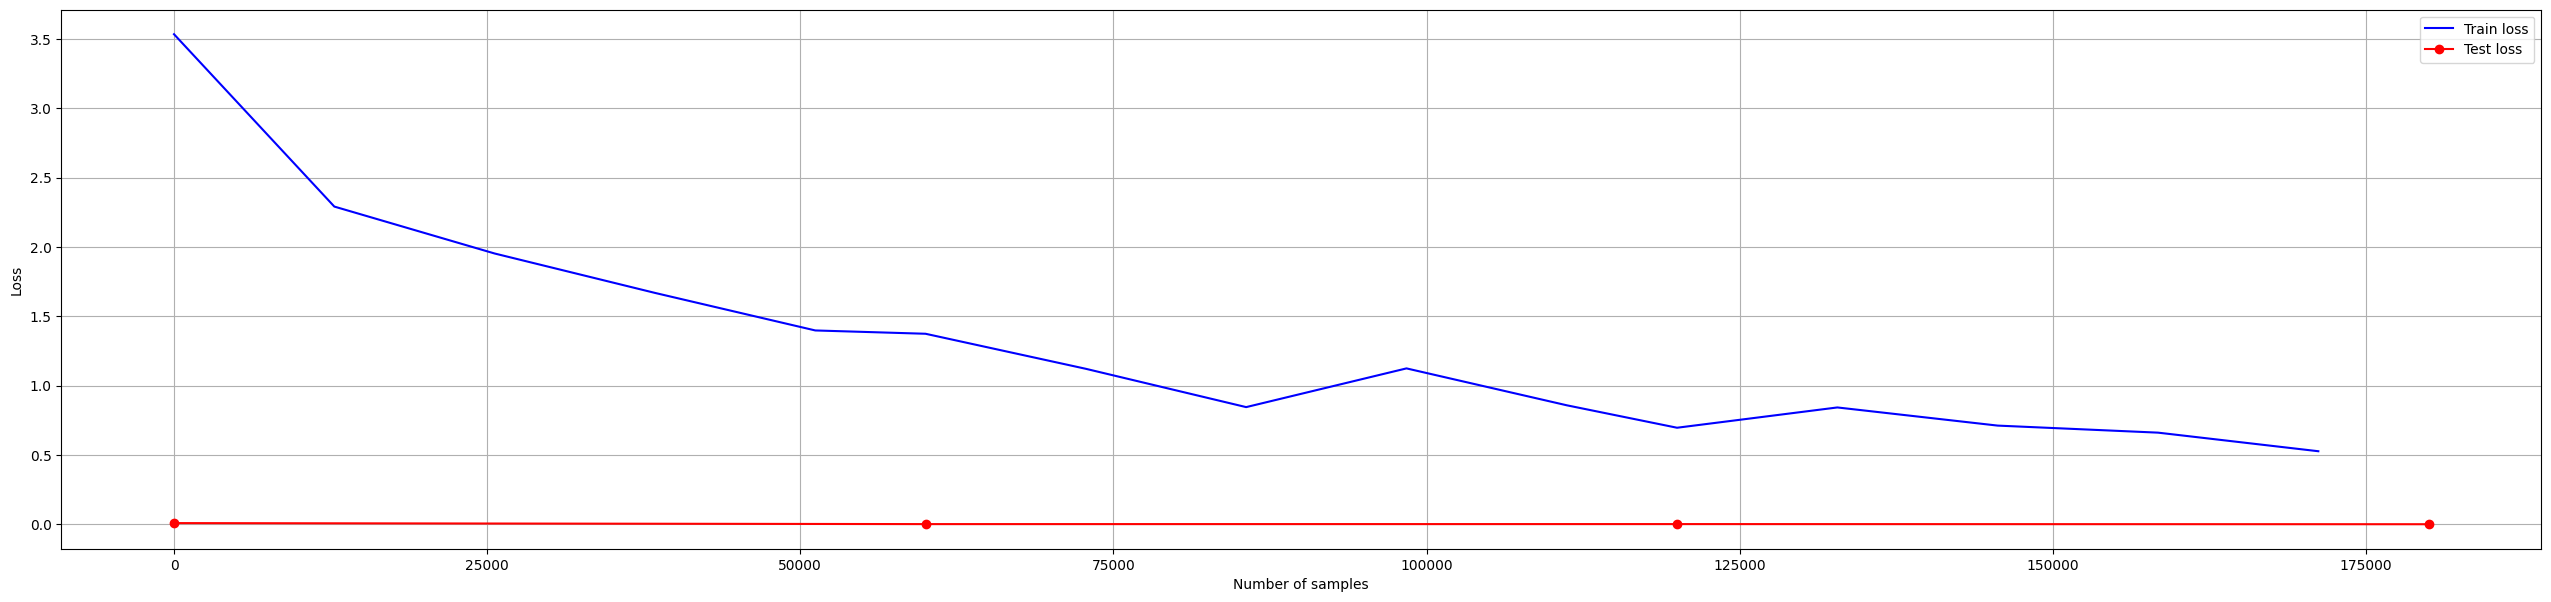

In [64]:
test_losses_total = np.array(test_losses_clsf) + np.array(test_losses_bbox)


fig = plt.figure(figsize=(32, 7))
plt.plot(train_counter, train_losses, color='blue', label='Train loss')
plt.plot(test_counter, test_losses_total, color='red',  marker='o', label='Test loss')


plt.legend(loc='upper right')
plt.xlabel('Number of samples')
plt.ylabel('Loss')
plt.grid()

In [66]:
state = {
    'model_state_dict': network.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'train_counter': train_counter,
    'test_losses_clsf': test_losses_clsf,
    'test_losses_bbox': test_losses_bbox,
    'test_counter': test_counter,
    'test_accuracies': test_accuracies
}
torch.save(state, 'models/detector.pth')

##### Na Colabu trenirao model s accuracyem od 90%, spremljen pod 'models/detector00001.pth', kako sam restartao bilježnicu, acc ovog zadnjeg je modela niži,a li koristim prethodno istreniran model na grafičkoj u cloudu.'

In [ ]:
"""
checkpoint = torch.load('models/detector00001.pth')

model = Net().to(device)
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

"""

#### Vizualni pregled - što model estimira?

Iskorisite sljedeći kod da bi vidjeli kako izgledaju predikcije Vašeg modela.

In [ ]:
with torch.no_grad():
    clsf_out, x1_out, y1_out, x2_out, y2_out = network(example_data.to(device))

plt.figure(figsize=(32, 32))
for idx in range(0, example_data.shape[0]):
    image = np.array(example_data[idx, 0, ...]).copy()

    x1, y1, x2, y2 = list(map(lambda x: int(x.item()), [x1_out[idx, ...], y1_out[idx, ...], x2_out[idx, ...], y2_out[idx, ...]]))
    image = cv2.rectangle(image, (x1, y1), (x2, y2), (2.5), 2)

    plt.subplot(12, 12, idx+1)
    plt.imshow(image)
    plt.title(np.argmax(clsf_out[idx, ...].cpu()))
    plt.xticks([])
    plt.yticks([])

#### Podzadatak d) - Evaluacija na neviđenom skupu podataka

Preuzmite skup podataka za ocjenjivanje sa sljedeće poveznice: https://drive.google.com/drive/folders/1baSno2jQSlyCPhk_liDlVvgXrIM5ojBB?usp=sharing -> **submission_z2.zip**

Primjer filea kojeg treba generirati možete preuzeti sa: https://drive.google.com/drive/folders/1baSno2jQSlyCPhk_liDlVvgXrIM5ojBB?usp=sharing -> **zad2_submission_sample.csv**

Odredite predikcije Vašeg najboljeg modela nad tim skupom, te ih stavite na Moodle.

In [ ]:
import zipfile
import os
import csv

with zipfile.ZipFile('submission_z2.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

model = network
model = model.to(device)
model.eval()

transform = torchvision.transforms.Compose([
                                torchvision.transforms.Resize((128,128)),
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Grayscale(num_output_channels=1),
                                torchvision.transforms.Normalize((0.1307,), (0.3081,))]
                               )

dataset = torchvision.datasets.ImageFolder('data', transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

results = []

for ind, (images, _) in enumerate(dataloader):
    images = images.to(device)

    clsf, x1, y1, x2, y2 = model(images)
    _, predicted_digit = torch.max(clsf, 1)

    image_name = dataset.imgs[ind][0].split('/')[-1]  # Extract image name
    results.append((image_name, predicted_digit.item(), x1.item(), y1.item(), x2.item(), y2.item()))

sorted_results = sorted(results, key=lambda x: int(x[0].split('_')[1][:-4]))

with open('submission_z2.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image_name', 'true_label', 'x1', 'y1', 'x2', 'y2'])
    writer.writerows(sorted_results)